In [143]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import scipy

np.random.seed(42)

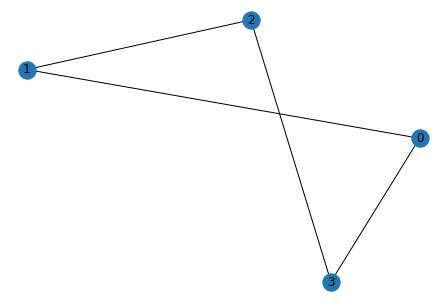

In [150]:
n_wires = 4
nodes = range(n_wires)
graph = [(0, 1), (1, 2), (2, 3), (0, 3)] # input the edges here. 3rd element of each tuple is the weight. 
graphy = nx.Graph() 
graphy.add_nodes_from(nodes)
graphy.add_edges_from(graph) # change 1
nx.draw(graphy, with_labels=True)
plt.show() 

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        print(' can come here')
        start_node = edge[0]
        end_node = edge[1]
        # weight = edge[2]
        pauli_z = [[1, 0], [0, -1]] # Define the Pauli-Z matrix. This is because we want to find the expected value of each edge pseudo-measured in the Z basis.
        pauli_z_2 = np.kron(pauli_z, pauli_z) # Takes the tensor product (or kronecker product) of 2 pauli Z matrices. This is because each edge has 2 vertices, each vertex is a qubit, so we need to take the expected value of 2 qubits in z basis, hence the tensor product of 2 z matrices.
        cost_unitary = scipy.linalg.fractional_matrix_power(pauli_z_2, -1*gamma/np.pi) # The unitary gate that will be applied to our circuit
        qml.Hermitian(cost_unitary, wires=[start_node, end_node]) # Note: wires = qubits. Here we are applying the unitary matrix we defined onto the 2 vertices of our edge.
        # the error seams to be in this last line: wires=[0, 1]) does not have a measurement type specified.


In [17]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    hold = qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires) # unless it is this line?
    return hold

In [18]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

In [137]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        # print(f'gammas: {gammas}')
        U_C(gammas[i])
        U_B(betas[i])
    hold = qml.sample(comp_basis_measurement(range(n_wires)))
    return hold        

In [103]:
def decimal_to_binary(decimal): # future: abstract this to take in lenght.
    binary_num = []
    
    def convert(decimal):
        if decimal >= 1:
            convert(decimal // 2)
            binary_num.append(decimal % 2)
    
    convert(decimal)
            
    for i in range(n_wires + 1):
        if len(binary_num) < i:
            binary_num.insert(0, 0) # At beginning append 0
    
    return binary_num # outputs array of bin.

In [145]:
n_layers = 4

def get_counts(params):
    # print("\np={:d}".format(n_layers))
    
    gammas = [params[0], params[2], params[4], params[6]]
    betas = [params[1], params[3], params[5], params[7]]
    
    # sample measured bitstrings 100 times
    bit_strings = []
    num_reps = 100
    for i in range(0, num_reps):
        # print("can come here")
        # print(f'params: {params}')
        # hold = int(circuit(params[0], params[1], edge=None, n_layers=n_layers)) change bc new optimizer
        circuit_out = circuit(gammas, betas, edge=None, n_layers=n_layers)
        hold = int(circuit_out)
        # print(f'What we are appending: {hold}')
        bit_strings.append(hold) # This appends the integer from 0-15 (if 4 nodes) so it outputs the computational basis measurement in decimal. 
        # print(f"int circuit right before int-ing: {circuit(params[0], params[1], edge=None, n_layers=n_layers)}")
        # print(f"int circuit: {int(circuit(params[0], params[1], edge=None, n_layers=n_layers))}")

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)

    return counts, bit_strings

In [114]:
# run decimal to binary to each eleemtn of bit_strings and then apply the cirq func

def get_binary_bit_strings(bit_strings):
    bit_strings_binary = []
    for bit in bit_strings:
        bit_strings_binary.append(decimal_to_binary(bit))
    return bit_strings_binary

In [115]:
# Cost function

def cost_function(params):
    # print(f'params at beginning of cost func: {params}')
    bit_strings = get_counts(params)[1]
    binary_bit_strings = get_binary_bit_strings(bit_strings)
    total_cost = 0
    for i in range(0, len(binary_bit_strings)):
        for edge in graph:
            start_node = edge[0]
            end_node = edge[1]
            unweighted_cost = 0.5*( ( (1 - 2*binary_bit_strings[i][start_node]) * (1 - 2*binary_bit_strings[i][end_node]) ) - 1)
            total_cost += unweighted_cost
        
    # total_cost = float(total_cost)/rep

    print("Cost: "+str(total_cost))

    return total_cost

In [153]:

# initialize the parameters near zero
init_params = 0.01 * np.random.rand(2, n_layers) # change 4 -> maxcut unrelated, just so i can have 3 layers.
params = init_params
# cost function here works. but not in the optimizer.
# print(f'init params: {params}')

from scipy.optimize import minimize
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':100}) # this line changes params from a 2x4 array into a 1x8 array. :/
print(f'Out: {out}')

 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here


ValueError: Observable Hermitian(array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99997478-0.00710167j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99997478-0.00710167j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 1.        +0.j        ]]), wires=[0, 1]) does not have a measurement type specified.

In [151]:
optimal_params = out['x'] # bruh this shit outputs in a 2x4 array
optimal_params_vector = []
for j in range(len(optimal_params[0])):
    optimal_params_vector.append(optimal_params[0][j])
    optimal_params_vector.append(optimal_params[1][j]) # optimal_params_vector is good
    
print(optimal_params_vector) # oh bruh this shit is an array not a tensor so it doesnt work wtf
final_bitstring_counts = get_counts(optimal_params_vector)[1]
print(final_bitstring)


[0.972266326023744, 0.9383259227508332, 0.048086386416432994, 0.05700101443947593, 0.9875152109139091, 1.011304442253277, 0.0759449121253904, 0.0805946397248798]
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here
 can come here


ValueError: Observable Hermitian(array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.56342862-0.82616475j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.56342862-0.82616475j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 1.        +0.j        ]]), wires=[0, 1]) does not have a measurement type specified.

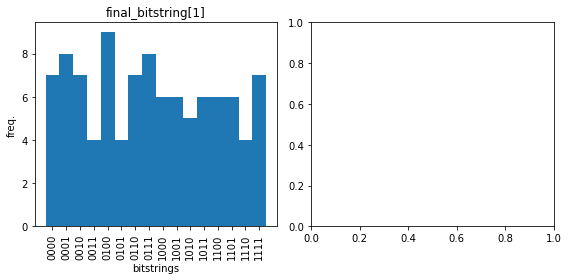

In [152]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("final_bitstring[1]")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(final_bitstring[1], bins=bins)
plt.subplot(1, 2, 2)

plt.tight_layout()
plt.show()